<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
    
Cette étude a été réalisée dans le cadre du 6ème projet de ma formation Datascientist dispensée en MOOC par 

<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>.




<p></p><p></p><p></p>





**Le problème posé :**


*Stack Overflow est un site célèbre de question-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.*

*Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tags pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.*



**Solutions mises en oeuvre**

Les solutions de suggestion de tags présentés ici se basent sur des modèles supervisés de machine learning.

Les modèles mis en oeuvre : 
* Multinomial Naive Bayes
* Multinomial Naive Bayes chaîné
* Gaussian Naive Bayes
* Bernoulli Naive Bayes
* Regression logistic (GSCV)
* Linear SVC
* SVM / SGD (GSCV) noyau Gaussien

Ce notebook utilise les données issues des notebooks : 


**`P6_DadaAnalysis.ipynb`**

**`P6_UnsupervizedMethods.ipynb`**



In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# <font color=blus>0. Data loading</font>

In [3]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV

import p6_util

def gscv_best_classifier_result(dict_param_grid, classifier, X_train, y_train\
                              , cls_name, X_test,y_test, dict_cls_score):
    ovr_classifier = OneVsRestClassifier(classifier)
    gscv_classifier  = GridSearchCV(ovr_classifier, dict_param_grid)
    
    gscv_classifier.fit(X_train, y_train)
    print (gscv_classifier.best_score_)
    print (gscv_classifier.best_params_)
    y_pred = gscv_classifier.best_estimator_.predict(X_test)
    cls_score = p6_util.p6_supervized_mean_accuracy_score(y_test, y_pred)
    print("Mean accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))
    dict_cls_score[cls_name]=cls_score
    return dict_cls_score, gscv_classifier.best_estimator_

    

In [4]:
import pandas as pd

import p5_util
import p6_util

is_reloaded = True

csr_matrix_tfidf_1gram_train = None
csr_matrix_encoded_train_tags=None

csr_matrix_tdif_1gram_test = None
csr_matrix_encoded_test_tags=None

file_name='./data/vectorizer_tfidf_ngram1_0.0002_.dump'
file_name='./data/vectorizer_tfidf_ngram1_b.dump'
vectorizer = p5_util.object_load(file_name)

if is_reloaded is True :
    #file_name="./data/csr_matrix_tfidf_1gram_train.dump" # 91% with KRR
    file_name='./data/csr_matrix_tfidf_1gram_train.dump'
    csr_matrix_tfidf_1gram_train = p5_util.object_load(file_name)
    print(csr_matrix_tfidf_1gram_train.shape)

    file_name='./data/csr_matrix_tdif_1gram_test.dump'
    csr_matrix_tdif_1gram_test = p5_util.object_load(file_name)
    print(csr_matrix_tdif_1gram_test.shape)
    
    file_name="./data/csr_matrix_encoded_train_tags.dump"
    csr_matrix_encoded_train_tags = p5_util.object_load(file_name)
    print(csr_matrix_encoded_train_tags.shape)

    file_name="./data/csr_matrix_encoded_test_tags.dump"
    csr_matrix_encoded_test_tags = p5_util.object_load(file_name)
    print(csr_matrix_encoded_test_tags.shape)
    
    # Processing test dataset from vectorizer and tokenized dataset.
    file_name='./data/ser_sof_body_test.dump'
    ser_sof_body_test = p5_util.object_load(file_name)

    csr_matrix_tdif_1gram_test = vectorizer.transform(ser_sof_body_test)
    print(csr_matrix_tdif_1gram_test.shape)
    
else :
    #file_name="./data/vectorizer_tfidf_ngram1_b.dump"
    file_name='./data/vectorizer_tfidf_ngram1_0.0002_.dump'
    vectorizer = p5_util.object_load(file_name)

    file_name="./data/train_StackOverFlow_BodyTitleTags.csv"
    ser_sof_tags_train=pd.read_csv(file_name)['Tags']
    print(ser_sof_tags_train.shape)

    file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
    ser_sof_tags_test=pd.read_csv(file_name)['Tags']
    print(ser_sof_tags_test.shape)

    if True :
        #-------------------------------------------------------------------------------
        # String of TAGs are converted as list of TAGS.
        #  * Multiple TAGs are assigned to a unique POST.
        # This lead to deal with a multi-label classification issue.
        # All labels (TAGs) are one hot encoded.
        #  * Train and test data-sets do not have same assigned TAGs set.
        # This leads to a different number of encoded columns for each data-set.
        # For having same number of columns for train and test datasets, 
        # encoding process uses the union of train and test assigned TAGs .
        #-------------------------------------------------------------------------------

        # List of referenced TAG is built...
        list_list_tags_train  \
        = ser_sof_tags_train.apply(p6_util.clean_marker_text, leading_marker='<', trailing_marker='>').tolist()
        print(len(list_list_tags_train))

        list_list_tags_test \
        = ser_sof_tags_test.apply(p6_util.clean_marker_text, leading_marker='<', trailing_marker='>').tolist()
        print(len(list_list_tags_test))
    
        #-------------------------------------------------------------------------------
        # List of referenced tags is built in order to process one hot encoding 
        #-------------------------------------------------------------------------------
        list_ref_tags = list()
        if False :
            #-------------------------------------------------------------------------------
            # List of referenced tags is built from TAGs issued both from train dataset and 
            # test dataset.
            #-------------------------------------------------------------------------------
            for list_tags in list_list_tags_train+list_list_tags_test :
                list_ref_tags += [tag for tag in list_tags]
        else :
            #-------------------------------------------------------------------------------
            # List of referenced tags is built from TAGs issued from train dataset only!
            #-------------------------------------------------------------------------------
            for list_tags in list_list_tags_train :
                list_ref_tags += [tag for tag in list_tags]

        list_ref_tags = list(set(list_ref_tags))
        print(len(list_ref_tags))
        file_name="./data/list_ref_tags.dump"
        p5_util.object_dump(list_ref_tags,file_name)
        
        #-------------------------------------------------------------------------------
    
    

        #-------------------------------------------------------------------------------
        # Assigned TAG from train dataset are encoded thanks to list_ref_tags
        #-------------------------------------------------------------------------------
        csr_matrix_encoded_train_tags, list_ref_train_tags \
        = p6_util.p6_encode_ser_tag_2_csrmatrix(ser_sof_tags_train, list_ref_tags)
        print("csr_matrix_encoded_train_tags : {}".format(csr_matrix_encoded_train_tags.shape))

        file_name="./data/csr_matrix_encoded_train_tags.dump"
        p5_util.object_dump(csr_matrix_encoded_train_tags,file_name)

        #-------------------------------------------------------------------------------
        # Assigned TAG from test dataset are encoded thanks to list_ref_tags
        #-------------------------------------------------------------------------------
        csr_matrix_encoded_test_tags, list_ref_test_tags \
        = p6_util.p6_encode_ser_tag_2_csrmatrix(ser_sof_tags_test, list_ref_tags)
        print("csr_matrix_encoded_test_tags : {}".format(csr_matrix_encoded_test_tags.shape))

        file_name="./data/csr_matrix_encoded_test_tags.dump"
        p5_util.object_dump(csr_matrix_encoded_test_tags,file_name)
        #-------------------------------------------------------------------------------
    

    #-------------------------------------------------------------------------------
    # Test dataset is standardized.
    #-------------------------------------------------------------------------------
    if False :
        file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
        df_sof_test=pd.read_csv(file_name)
        print(df_sof_test.shape)

        df_sof_test['Body']=df_sof_test['Body']+df_sof_test['Title']
        ser_sof_body_test = p6_util.p6_df_standardization(df_sof_test.Body)

        file_name='./data/ser_sof_body_test.dump'
        p5_util.object_dump(ser_sof_body_test, file_name)

        #-------------------------------------------------------------------------------
        # Train dataset is standardized.
        #-------------------------------------------------------------------------------
        file_name="./data/train_StackOverFlow_BodyTitleTags.csv"
        df_sof_train=pd.read_csv(file_name)
        print(df_sof_train.shape)

        df_sof_train['Body']=df_sof_train['Body']+df_sof_train['Title']
        ser_sof_body_train = p6_util.p6_df_standardization(df_sof_train.Body)

        file_name='./data/ser_sof_body_train.dump'
        p5_util.object_dump(ser_sof_body_train, file_name)

    #-------------------------------------------------------------------------------
    # Train dataset is digitalized
    #-------------------------------------------------------------------------------
    print("Train dataset digitalization")
    file_name='./data/ser_sof_body_train.dump'
    ser_sof_body_train = p5_util.object_load(file_name)
    csr_matrix_tfidf_1gram_train = vectorizer.transform(ser_sof_body_train)
    file_name='./data/csr_matrix_tfidf_1gram_train.dump'
    p5_util.object_dump(csr_matrix_tfidf_1gram_train,file_name)
    print(csr_matrix_tfidf_1gram_train.shape)


    #-------------------------------------------------------------------------------
    # Test dataset is digitalized
    #-------------------------------------------------------------------------------
    print("Test dataset digitalization")
    file_name='./data/ser_sof_body_test.dump'
    ser_sof_body_test = p5_util.object_load(file_name)
    csr_matrix_tdif_1gram_test = vectorizer.transform(ser_sof_body_test)
    file_name='./data/csr_matrix_tdif_1gram_test.dump'
    p5_util.object_dump(csr_matrix_tdif_1gram_test,file_name)
    print(csr_matrix_tdif_1gram_test.shape)


if None is csr_matrix_tfidf_1gram_train :
    file_name="./data/csr_matrix_tdif_1gram_test.dump"
    csr_matrix_tfidf_1gram_test = p5_util.object_load(file_name)
else :
    pass

if None is csr_matrix_tfidf_1gram_train :
    file_name="./data/csr_matrix_tfidf_ngram1_b.dump"
    csr_matrix_tfidf_1gram_train = p5_util.object_load(file_name)
else:
    pass

X_train = csr_matrix_tfidf_1gram_train
y_train = csr_matrix_encoded_train_tags

X_test = csr_matrix_tdif_1gram_test
y_test = csr_matrix_encoded_test_tags

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

p5_util.object_load : fileName= ./data/vectorizer_tfidf_ngram1_b.dump
p5_util.object_load : fileName= ./data/csr_matrix_tfidf_1gram_train.dump
(24604, 6448)
p5_util.object_load : fileName= ./data/csr_matrix_tdif_1gram_test.dump
(16359, 6448)
p5_util.object_load : fileName= ./data/csr_matrix_encoded_train_tags.dump
(24604, 6436)
p5_util.object_load : fileName= ./data/csr_matrix_encoded_test_tags.dump
(16359, 6436)
p5_util.object_load : fileName= ./data/ser_sof_body_test.dump


/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.0 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.0 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(16359, 6448)
(24604, 6448) (24604, 6436) (16359, 6448) (16359, 6436)


In [5]:
file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
ser_sof_tags_test=pd.read_csv(file_name)['Tags']
print(ser_sof_tags_test.shape)

ser_sof_tags_test = ser_sof_tags_test.apply(p6_util.clean_marker_text, leading_marker='<', trailing_marker='>')

(16359,)


Building referenced list of TAG; referenced list is built from train dataset.

Removing rows from tokenized test dataset with TAG that are not into list of TAG from train dataset

In [6]:
import p5_util

file_name="./data/train_StackOverFlow_BodyTitleTags.csv"
ser_sof_tags_train=pd.read_csv(file_name)['Tags']
print(ser_sof_tags_train.shape)

# List of referenced TAG is built...
list_list_tags_train  \
= ser_sof_tags_train.apply(p6_util.clean_marker_text, leading_marker='<', trailing_marker='>').tolist()
print(len(list_list_tags_train))

list_ref_tags = list()
for list_tags in list_list_tags_train :
    list_ref_tags += [tag for tag in list_tags]
    
list_unique_tags_train = list(set(list_ref_tags))
print(len(list_unique_tags_train))

filename='./data/list_unique_tags_train'
p5_util.object_dump(list_unique_tags_train,filename)

(24604,)
24604
6436


In [7]:
list_row_keep = list()
ser_sof_test_restricted=  pd.Series()
print(len(ser_sof_tags_test))
#-------------------------------------------------------------------------------------
# TAGS from test dataset that are not into list of TAG from train dataset are removed
#-------------------------------------------------------------------------------------
for row, list_tag_row in ser_sof_tags_test.items():
    is_inserted = True
    for tag_row in list_tag_row :
        if tag_row not in list_unique_tags_train :
            is_inserted = False
            break
        else: 
            pass
    if is_inserted is True :
        list_row_keep.append(row)
    else :
        #print(list_tag_row)
        pass

print(len(list_row_keep)/len(ser_sof_tags_test))
print(len(list_row_keep))

X_test = X_test[list_row_keep]
ser_sof_tags_test = ser_sof_tags_test.iloc[list_row_keep]
X_test.shape, ser_sof_tags_test.shape

y_test = y_test[list_row_keep]
y_test.shape

X_train = X_train[list_row_keep]
X_train.shape

y_train = y_train[list_row_keep]
y_train.shape

X_train.shape, X_test.shape, y_train.shape, y_test.shape

16359
0.8656397090286693
14161


((14161, 6448), (14161, 6448), (14161, 6436), (14161, 6436))

# <font color=blus>4. Supervized methods</font>

## <font color=blus>4.1. Bernoulli Naive Bayes </font>

In [ ]:
del(best_classfier)

In [ ]:
from sklearn.naive_bayes import BernoulliNB

import p5_util
import p6_util

cls_name = 'Bernoulli NB'

file_name_score='./data/dict_cls_score.dump'
dict_cls_score = p5_util.object_load(file_name_score)

file_name_cls = './data/classifier_best_BernoulliNB.dump'
is_reloaded=True
if is_reloaded is False :

    dict_param_grid = {
        'estimator__alpha': [ 1.e-4, 5.e-4, 1.e-3, 5.e-3, 1.e-2, 5.e-2, 1.e-1], #
        'n_jobs': [-1]
    }

    dict_cls_score, best_classfier = gscv_best_classifier_result(dict_param_grid, BernoulliNB()\
                                               , X_train, y_train\
                                               , cls_name, X_test, y_test, dict_cls_score)

    p5_util.object_dump(best_classfier, file_name_cls)
else :
    best_classfier= p5_util.object_load(file_name_cls)

    y_pred = best_classfier.predict(X_test)
    cls_score = p6_util.p6_supervized_mean_accuracy_score(y_test, y_pred)
    print("Mean accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))

    dict_cls_score[cls_name] = cls_score

p5_util.object_dump(dict_cls_score, file_name_score)
dict_cls_score

**Compute accuracy**

## <font color=blus>4.2. Applying Naive Bayes classifier</font>

one versus Rest leads having one classifier per class.

`OneVsRestClassifier` classifier is used because of multiple classes. 

Then, one classifier per class is fitted.



In [9]:
from sklearn.naive_bayes import MultinomialNB


import p5_util
import p6_util

cls_name = 'Multinomial NB'

file_name_score='./data/dict_cls_score.dump'
dict_cls_score = p5_util.object_load(file_name_score)

file_name_cls = './data/classifier_best_MultinomialNB.dump'
is_reloaded=False
if is_reloaded is False :

    dict_param_grid = {
        #'estimator__alpha': [  1.e-1,], # 3.17%
        'estimator__alpha': [  1.e-3,], # 5.14%
        #'estimator__alpha': [ 1.e-3, 5.e-2, 1.e-1, 5.e-1], #1.e-3 : 5.14%
        #'estimator__alpha': [ 1.e-4, 5.e-4, 6.e-4,1.e-3], #1.e-3 : 5.14%
        'n_jobs': [-1]
    }

    dict_cls_score, best_classfier = gscv_best_classifier_result(dict_param_grid, MultinomialNB()\
                                               , X_train, y_train\
                                               , cls_name, X_test, y_test, dict_cls_score)

    p5_util.object_dump(best_classfier, file_name_cls)
else :
    best_classfier= p5_util.object_load(file_name_cls)

    y_pred = best_classfier.predict(X_test)
    cls_score = p6_util.p6_supervized_mean_accuracy_score(y_test, y_pred)
    print("Mean accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))

    dict_cls_score[cls_name] = cls_score

p5_util.object_dump(dict_cls_score, file_name_score)
dict_cls_score

p5_util.object_load : fileName= ./data/dict_cls_score.dump
0.011016171174352093
{'estimator__alpha': 0.001, 'n_jobs': -1}
Mean accuracy score for Multinomial NB : 5.14 %


{'Logistic Regression': 0.2464188351920694,
 'Bernoulli NB': 0.24287484510532836,
 'Chained Multinomial NB': 0.00013160780872998465,
 'Multinomial NB': 0.051425030978934326,
 'SVM/SGD': 0.2110532837670384,
 'Gaussian NB': 0.1709541511771995,
 'Kernel SVC': 0.0,
 'Linear SVC': 0.23070631970260222,
 'Kernel Ridge': 0.9173482032218092,
 'KRR Polynomial': 0.9113506815365552,
 'KRR Linear': 0.8630978934324659,
 'KRR Classifier': 0.23368029739776952,
 'MNB': 0.011369253583786456,
 'SVM SGD Classifier': 0.0}

**Compute accuracy**

## <font color='blus'>4.3. Chained Multinomial Naive Bayes classifier</font>

In [ ]:
#from sklearn.multioutput import ClassifierChain
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import MultinomialNB
import p5_util

file_name='./data/classifier_best_MNBChained.dump'

if is_reloaded is False :
    chained_classifier_mnb = ClassifierChain(MultinomialNB(alpha=1.e-3))

    chained_classifier_mnb.fit(X_train , y_train)

    p5_util.object_dump(chained_classifier_mnb, file_name)
else : 
    chained_classifier_mnb = p5_util.object_load(file_name)
    

In [ ]:
import p5_util
import p6_util

y_pred = chained_classifier_mnb.predict(X_test)

cls_name = 'Chained Multinomial NB'
cls_score = p6_util.p6_supervized_mean_accuracy_score(y_test, y_pred)
print("Mean accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))


file_name="./data/dict_cls_score.dump"
dict_cls_score = p5_util.object_load(file_name)
dict_cls_score[cls_name] = cls_score

file_name='./data/dict_cls_score.dump'
p5_util.object_dump(dict_cls_score, file_name)
dict_cls_score

In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import BernoulliNB

chained_classifier_ber = ClassifierChain(BernoulliNB(alpha=5.e-2))


chained_classifier_ber.fit(X_train , y_train)

y_pred = chained_classifier_ber.predict(X_test)

In [ ]:
import p5_util
import p6_util

cls_name = 'Chained Bernoulli NB'
cls_score = p6_util.p6_supervized_mean_accuracy_score(y_test, y_pred)
print("Mean accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))


file_name="./data/dict_cls_score.dump"
dict_cls_score = p5_util.object_load(file_name)
dict_cls_score[cls_name] = cls_score

file_name='./data/dict_cls_score.dump'
p5_util.object_dump(dict_cls_score, file_name)
dict_cls_score

## <font color='blus'>4.4. SVM/SGD classifier</font>

In [12]:
from sklearn.linear_model import SGDClassifier

import p5_util
import p6_util

cls_name='SVM SGD Classifier'

file_name_score='./data/dict_cls_score.dump'
dict_cls_score = p5_util.object_load(file_name_score)

file_name_cls = './data/classifier_best_SVM_SGD.dump'
is_reloaded=False
if is_reloaded is False :
    dict_param_grid = {
        'estimator__loss':['hinge'],
        #'estimator__alpha': [1e-3, 5*1e-3, 1e-2, 5e-2, 1e-1,5e-1,1.,10,20],#3,51%
        #'estimator__alpha': [1.e-4, 5.e-4,1e-3],#16,6%
        'estimator__alpha': [1.e-5, 5.e-5,1e-4],#16,6%
        #'estimator__alpha': [ 1e-1],
        'estimator__penalty': ['l2'],
        'n_jobs': [-1]
    }


    dict_cls_score, best_classfier = gscv_best_classifier_result(dict_param_grid, SGDClassifier()\
                                               , X_train, y_train\
                                               , cls_name, X_test, y_test, dict_cls_score)

    p5_util.object_dump(best_classfier, file_name_cls)
else :
    best_classfier= p5_util.object_load(file_name_cls)

    y_pred = best_classfier.predict(X_test)
    cls_score = p6_util.p6_supervized_mean_accuracy_score(y_test, y_pred)
    print("Mean accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))

    dict_cls_score[cls_name] = cls_score

p5_util.object_dump(dict_cls_score, file_name_score)
dict_cls_score

p5_util.object_load : fileName= ./data/dict_cls_score.dump
0.051691264741190596
{'estimator__alpha': 5e-05, 'estimator__loss': 'hinge', 'estimator__penalty': 'l2', 'n_jobs': -1}
Mean accuracy score for SVM SGD Classifier : 21.15 %


{'Logistic Regression': 0.2464188351920694,
 'Bernoulli NB': 0.24287484510532836,
 'Chained Multinomial NB': 0.00013160780872998465,
 'Multinomial NB': 0.051425030978934326,
 'SVM/SGD': 0.2110532837670384,
 'Gaussian NB': 0.1709541511771995,
 'Kernel SVC': 0.0,
 'Linear SVC': 0.23070631970260222,
 'Kernel Ridge': 0.9173482032218092,
 'KRR Polynomial': 0.9113506815365552,
 'KRR Linear': 0.8630978934324659,
 'KRR Classifier': 0.23368029739776952,
 'MNB': 0.011369253583786456,
 'SVM SGD Classifier': 0.21152416356877324}

## <font color='blus'>4.5. Grid Search CV Logistic regression & One vs rest</font>

In [13]:
from sklearn.linear_model import LogisticRegression

import p5_util
import p6_util

cls_name='Logistic Regression'
file_name_score='./data/dict_cls_score.dump'
dict_cls_score = p5_util.object_load(file_name_score)

file_name_cls = './data/classifier_best_logisticRegression.dump'
is_reloaded=True
if is_reloaded is False :
    dict_param_grid = {
        #'estimator__C': [ 150,200],#0.011350681536555142,
        #'estimator__C': [ 0.01, 0.1,1.], #0.0
        #'estimator__C': [ 100,150],
        'estimator__C': [ 150], # Best classifier
        'estimator__penalty': ['l2'],
        'n_jobs': [-1]
    }

    dict_cls_score, best_classfier = gscv_best_classifier_result(dict_param_grid, LogisticRegression()\
                                               , X_train, y_train\
                                               , cls_name, X_test, y_test, dict_cls_score)

    p5_util.object_dump(best_classfier, file_name_cls)
else :
    best_classfier= p5_util.object_load(file_name_cls)

    y_pred = best_classfier.predict(X_test)
    cls_score = p6_util.p6_supervized_mean_accuracy_score(y_test, y_pred)
    print("Mean accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))

    dict_cls_score[cls_name] = cls_score

p5_util.object_dump(dict_cls_score, file_name_score)
dict_cls_score

p5_util.object_load : fileName= ./data/dict_cls_score.dump
p5_util.object_load : fileName= ./data/classifier_best_logisticRegression.dump


/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.0 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.20.0 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator _ConstantPredictor from version 0.20.0 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator OneVsRestClassifier from version 0.20.0 when using version 0.20.2. This might le

Mean accuracy score for Logistic Regression : 24.64 %


{'Logistic Regression': 0.2464188351920694,
 'Bernoulli NB': 0.24287484510532836,
 'Chained Multinomial NB': 0.00013160780872998465,
 'Multinomial NB': 0.051425030978934326,
 'SVM/SGD': 0.2110532837670384,
 'Gaussian NB': 0.1709541511771995,
 'Kernel SVC': 0.0,
 'Linear SVC': 0.23070631970260222,
 'Kernel Ridge': 0.9173482032218092,
 'KRR Polynomial': 0.9113506815365552,
 'KRR Linear': 0.8630978934324659,
 'KRR Classifier': 0.23368029739776952,
 'MNB': 0.011369253583786456,
 'SVM SGD Classifier': 0.21152416356877324}

In [ ]:
X_train.shape, y_train.shape

## <font color='blus'>4.6. Grid search for SVM classifier with SGD</font>

In [54]:
file_name_cls = './data/classifier_best_SVM_SGD.dump'
p5_util.object_load(file_name_cls)

p5_util.object_load : fileName= ./data/classifier_best_SVM_SGD.dump


OneVsRestClassifier(estimator=SGDClassifier(alpha=5e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=-1)

In [14]:
from sklearn.linear_model import SGDClassifier

import p5_util
import p6_util

cls_name='SVM SGD Classifier'

file_name_score='./data/dict_cls_score.dump'
dict_cls_score = p5_util.object_load(file_name_score)

file_name_cls = './data/classifier_best_SVM_SGD.dump'
is_reloaded=True
if is_reloaded is False :
    dict_param_grid = {
        'estimator__loss':['hinge'],
        'estimator__alpha': [1e-3, 5*1e-3, 1e-2, 5e-2, 1e-1,5e-1,1.,10,20],
        'estimator__alpha': [ 1e-1],
        'estimator__penalty': ['l2'],
        'n_jobs': [-1]
    }


    dict_cls_score, best_classfier = gscv_best_classifier_result(dict_param_grid, SGDClassifier()\
                                               , X_train, y_train\
                                               , cls_name, X_test, y_test, dict_cls_score)

    p5_util.object_dump(best_classfier, file_name_cls)
else :
    best_classfier= p5_util.object_load(file_name_cls)

    y_pred = best_classfier.predict(X_test)
    cls_score = p6_util.p6_supervized_mean_accuracy_score(y_test, y_pred)
    print("Mean accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))

    dict_cls_score[cls_name] = cls_score

p5_util.object_dump(dict_cls_score, file_name_score)
dict_cls_score

p5_util.object_load : fileName= ./data/dict_cls_score.dump
p5_util.object_load : fileName= ./data/classifier_best_SVM_SGD.dump
Mean accuracy score for SVM SGD Classifier : 21.15 %


{'Logistic Regression': 0.2464188351920694,
 'Bernoulli NB': 0.24287484510532836,
 'Chained Multinomial NB': 0.00013160780872998465,
 'Multinomial NB': 0.051425030978934326,
 'SVM/SGD': 0.2110532837670384,
 'Gaussian NB': 0.1709541511771995,
 'Kernel SVC': 0.0,
 'Linear SVC': 0.23070631970260222,
 'Kernel Ridge': 0.9173482032218092,
 'KRR Polynomial': 0.9113506815365552,
 'KRR Linear': 0.8630978934324659,
 'KRR Classifier': 0.23368029739776952,
 'MNB': 0.011369253583786456,
 'SVM SGD Classifier': 0.21152416356877324}

## <font color='blus'>4.7. Powered SGD classifier</font>

In [ ]:
from sklearn.linear_model import SGDClassifier
from skmultilearn.problem_transform import LabelPowerset
power_classifier_sgd = LabelPowerset(SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None))
power_classifier_sgd.fit(X_train, y_train)

y_pred = power_classifier_sgd.predict(X_test)

power_classifier_sgd_score = accuracy_score(y_test[:,:col_min]  ,y_pred[:,:col_min])

print("Accuracy mean score for Powered SGD classifier : {0:1.2F} %".format(power_classifier_sgd_score*100))

dict_cls_score['Powered SGD'] = power_classifier_sgd_score

In [ ]:
import p5_util
file_name='./data/dict_cls_score.dump'
dict_cls_score = p5_util.object_load(file_name)

dict_cls_score['GSCV SGD Regression'] = gscv_sgd_cls.best_score_
p5_util.object_dump(dict_cls_score, file_name)

## <font color='blus'>4.8. Gaussian Naive Bayes classifier</font>

In [ ]:
from sklearn.naive_bayes import GaussianNB
from scipy import sparse


import p5_util
import p6_util

cls_name='Gaussian NB'

file_name_score='./data/dict_cls_score.dump'
dict_cls_score = p5_util.object_load(file_name_score)

file_name_cls = './data/classifier_GaussianNB.dump'
is_reloaded=True
if is_reloaded is False :

    dict_param_grid = {
        'estimator__alpha': [ 1e-1],
        'estimator__penalty': ['l2'],
        'n_jobs': [-1]
    }

    dict_cls_score, best_classfier = gscv_best_classifier_result(dict_param_grid, GaussianNB()\
                                               , X_train, y_train\
                                               , cls_name, X_test, y_test, dict_cls_score)

    p5_util.object_dump(best_classfier, file_name_cls)
else :
    best_classfier= p5_util.object_load(file_name_cls)

    y_pred = best_classfier.predict(X_test.toarray())
    

    y_pred_csr = sparse.csr_matrix(y_pred)

    cls_score = p6_util.p6_supervized_mean_accuracy_score(y_test, y_pred_csr)
    print("Mean accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))

    dict_cls_score[cls_name] = cls_score

p5_util.object_dump(dict_cls_score, file_name_score)
dict_cls_score

In [18]:
dict_cls_score

{'Logistic Regression': 0.2464188351920694,
 'Bernoulli NB': 0.24287484510532836,
 'Chained Multinomial NB': 0.00013160780872998465,
 'Multinomial NB': 0.051425030978934326,
 'SVM/SGD': 0.2110532837670384,
 'Gaussian NB': 0.004163568773234201,
 'Kernel SVC': 0.0,
 'Linear SVC': 0.23070631970260222,
 'Kernel Ridge': 0.9173482032218092,
 'KRR Polynomial': 0.9113506815365552,
 'KRR Linear': 0.8630978934324659,
 'KRR Classifier': 0.23368029739776952,
 'MNB': 0.011369253583786456,
 'SVM SGD Classifier': 0.21152416356877324}

## <font color='blus'>4.9. SVC Kernel rbf classifier</font>

In [43]:
type(X_test)

scipy.sparse.csr.csr_matrix

In [52]:
from sklearn import svm

import p5_util
import p6_util

is_reloaded=False

cls_name = 'Kernel SVC'

file_name_score='./data/dict_cls_score.dump'
dict_cls_score = p5_util.object_load(file_name_score)

file_name_cls = './data/classifier_SVCKernel.dump'
if is_reloaded is False :

    dict_param_grid = {
        #'estimator__C': [ 10.,100.],# Best : 100 --> 0.86%
        'estimator__C': [ 100.,200.],# Best : 200 --> 2,94%
    }

    dict_cls_score, best_classfier = gscv_best_classifier_result(dict_param_grid, svm.SVC(kernel='rbf')\
                                               , X_train, y_train\
                                               , cls_name, X_test, y_test, dict_cls_score)

    p5_util.object_dump(best_classfier, file_name_cls)
else :
    best_classfier= p5_util.object_load(file_name_cls)

    y_pred = best_classfier.predict(X_test.toarray())
    

    y_pred_csr = sparse.csr_matrix(y_pred)

    cls_score = p6_util.p6_supervized_mean_accuracy_score(y_test, y_pred_csr)
    print("Mean accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))

    dict_cls_score[cls_name] = cls_score

p5_util.object_dump(dict_cls_score, file_name_score)
dict_cls_score

p5_util.object_load : fileName= ./data/dict_cls_score.dump
0.0036720570581173645
{'estimator__C': 200.0}
Mean accuracy score for Kernel SVC : 2.94 %


{'Logistic Regression': 0.2464188351920694,
 'Bernoulli NB': 0.24287484510532836,
 'Chained Multinomial NB': 0.00013160780872998465,
 'Multinomial NB': 0.051425030978934326,
 'SVM/SGD': 0.2110532837670384,
 'Gaussian NB': 0.004163568773234201,
 'Kernel SVC': 0.02939281288723668,
 'Linear SVC': 0.244089219330855,
 'Kernel Ridge': 0.9173482032218092,
 'KRR Polynomial': 0.9113506815365552,
 'KRR Linear': 0.8630978934324659,
 'KRR Classifier': 0.23368029739776952,
 'MNB': 0.011369253583786456,
 'SVM SGD Classifier': 0.21152416356877324}

In [49]:
from sklearn import svm
dict_param_grid = {
    'estimator__C': [ 1.,],
    #'n_jobs': [-1]
}

svc_classifier = OneVsRestClassifier(svm.SVC(kernel='rbf'))
gscv_classifier  = GridSearchCV(svc_classifier, dict_param_grid)

gscv_classifier.fit(X_train, y_train)

y_pred = gscv_classifier.predict(X_test)

/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 16 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 26 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 30 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 36 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 39 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 48 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-pack

/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 400 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 404 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 407 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 420 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 430 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 439 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/sit

/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 842 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 847 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 849 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 855 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 863 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 865 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/sit

/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1140 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1155 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1169 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1176 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1194 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1203 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3

/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1532 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1540 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1544 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1551 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1553 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1561 is present in all training examples.
  str(classes[c]))


KeyboardInterrupt: 

In [45]:
cls_name = 'Kernel SVC'
cls_score = p6_util.p6_supervized_mean_accuracy_score(y_test, y_pred)
print("Mean accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))

file_name = './data/dict_cls_score.dump'
dict_cls_score = p5_util.object_load(file_name)
dict_cls_score[cls_name] = cls_score
p5_util.object_dump(dict_cls_score, file_name)

file_name = './data/classifier_SVCKernel.dump'
p5_util.object_dump(svc_classifier, file_name)

dict_cls_score

Mean accuracy score for Kernel SVC : 0.00 %
p5_util.object_load : fileName= ./data/dict_cls_score.dump


{'Logistic Regression': 0.2464188351920694,
 'Bernoulli NB': 0.24287484510532836,
 'Chained Multinomial NB': 0.00013160780872998465,
 'Multinomial NB': 0.051425030978934326,
 'SVM/SGD': 0.2110532837670384,
 'Gaussian NB': 0.004163568773234201,
 'Kernel SVC': 0.0,
 'Linear SVC': 0.244089219330855,
 'Kernel Ridge': 0.9173482032218092,
 'KRR Polynomial': 0.9113506815365552,
 'KRR Linear': 0.8630978934324659,
 'KRR Classifier': 0.23368029739776952,
 'MNB': 0.011369253583786456,
 'SVM SGD Classifier': 0.21152416356877324}

## <font color='blus'>4.10. Linear SVC</font>

In [34]:
from sklearn import svm

import p5_util
import p6_util

cls_name = 'Linear SVC'


file_name_score='./data/dict_cls_score.dump'
dict_cls_score = p5_util.object_load(file_name_score)

is_reloaded=True

if is_reloaded is True :
    file_name_cls = './data/classifier_LinearSVC.dump'
else :
    file_name_cls = './data/classifier_best_LinearSVC.dump'
    
if is_reloaded is False :

    dict_param_grid = {
        #'estimator__C': [ 1e-1,5e-1,1.,0.5,10], # ~0%
        #'estimator__C': [ 1.],# 23%
        'estimator__C': [ 0.5,1.,1.5],#24,41 %
        'n_jobs': [-1]
    }

    dict_cls_score, best_classfier = gscv_best_classifier_result(dict_param_grid, LinearSVC(multi_class='ovr')\
                                               , X_train, y_train\
                                               , cls_name, X_test, y_test, dict_cls_score)

    p5_util.object_dump(best_classfier, file_name_cls)
else :
    best_classfier= p5_util.object_load(file_name_cls)

    #y_pred = best_classfier.predict(X_test.toarray())
    y_pred = best_classfier.predict(X_test)
    

    #y_pred_csr = sparse.csr_matrix(y_pred)

    #cls_score = p6_util.p6_supervized_mean_accuracy_score(y_test, y_pred_csr)
    cls_score = p6_util.p6_supervized_mean_accuracy_score(y_test, y_pred)
    print("Mean accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))

    dict_cls_score[cls_name] = cls_score

p5_util.object_dump(dict_cls_score, file_name_score)
dict_cls_score

p5_util.object_load : fileName= ./data/dict_cls_score.dump


/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.048231057128733844
{'estimator__C': 1.5, 'n_jobs': -1}
Mean accuracy score for Linear SVC : 24.41 %


{'Logistic Regression': 0.2464188351920694,
 'Bernoulli NB': 0.24287484510532836,
 'Chained Multinomial NB': 0.00013160780872998465,
 'Multinomial NB': 0.051425030978934326,
 'SVM/SGD': 0.2110532837670384,
 'Gaussian NB': 0.004163568773234201,
 'Kernel SVC': 0.0,
 'Linear SVC': 0.244089219330855,
 'Kernel Ridge': 0.9173482032218092,
 'KRR Polynomial': 0.9113506815365552,
 'KRR Linear': 0.8630978934324659,
 'KRR Classifier': 0.23368029739776952,
 'MNB': 0.011369253583786456,
 'SVM SGD Classifier': 0.21152416356877324}

Default value here-under for linear SVC provides precision of 23%

In [31]:
from sklearn.svm import LinearSVC
svc_linsvc = OneVsRestClassifier(LinearSVC(multi_class='ovr'))

svc_linsvc.fit(X_train, y_train)
y_pred = svc_linsvc.predict(X_test)

cls_name = 'Linear SVC'
cls_score = p6_util.p6_supervized_mean_accuracy_score(y_test, y_pred)
print("Mean accuracy score for "+cls_name+" : {0:1.2F} %".format(cls_score*100))

file_name = './data/dict_cls_score.dump'
dict_cls_score = p5_util.object_load(file_name)
dict_cls_score[cls_name] = cls_score
p5_util.object_dump(dict_cls_score, file_name)

file_name = './data/classifier_LinearSVC.dump'
p5_util.object_dump(svc_linsvc, file_name)

dict_cls_score

Mean accuracy score for Linear SVC : 23.07 %
p5_util.object_load : fileName= ./data/dict_cls_score.dump


{'Logistic Regression': 0.2464188351920694,
 'Bernoulli NB': 0.24287484510532836,
 'Chained Multinomial NB': 0.00013160780872998465,
 'Multinomial NB': 0.051425030978934326,
 'SVM/SGD': 0.2110532837670384,
 'Gaussian NB': 0.004163568773234201,
 'Kernel SVC': 0.0,
 'Linear SVC': 0.23070631970260222,
 'Kernel Ridge': 0.9173482032218092,
 'KRR Polynomial': 0.9113506815365552,
 'KRR Linear': 0.8630978934324659,
 'KRR Classifier': 0.23368029739776952,
 'MNB': 0.011369253583786456,
 'SVM SGD Classifier': 0.21152416356877324}

In [32]:
svc_linsvc

OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=None)

## <font color='blus'>4.11. Kernel Ridge</font>

## <font color='blus'>4.11.1. Kernel Ridge: Gaussian kernel</font>

## <font color='blus'>4.11.2. Kernel Ridge: Polynomial kernel</font>

## <font color='blus'>4.11.3. Kernel Ridge: Linear kernel</font>

## <font color='blus'>4.12. Kernel Ridge Classfier</font>

In [57]:
from sklearn.linear_model import RidgeClassifier
#krr_classfier = RidgeClassifier()
#krr_classfier.fit(X_train, y_train)
file_name = './data/dict_cls_score.dump'
dict_cls_score = p5_util.object_load(file_name)
dict_param_grid = {
    'estimator__alpha': [ 0.1,1.,10.],
    'n_jobs': [-1]
}
cls_name='KRR Classifier'
dict_cls_score, best_classfier = gscv_best_classifier_result(dict_param_grid, RidgeClassifier(), X_train, y_train\
                              , cls_name, X_test,y_test, dict_cls_score)
dict_cls_score

p5_util.object_load : fileName= ./data/dict_cls_score.dump


/home/bangui/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.04837229009250759
{'estimator__alpha': 0.1, 'n_jobs': -1}
Mean accuracy score for KRR Classifier : 23.36 %


{'Logistic Regression': 0.2464188351920694,
 'Bernoulli NB': 0.24287484510532836,
 'Chained Multinomial NB': 0.00013160780872998465,
 'Multinomial NB': 0.051425030978934326,
 'SVM/SGD': 0.2110532837670384,
 'Gaussian NB': 0.004163568773234201,
 'Kernel SVC': 0.02939281288723668,
 'Linear SVC': 0.244089219330855,
 'KRR Classifier': 0.23363073110285007,
 'MNB': 0.011369253583786456,
 'SVM SGD Classifier': 0.21152416356877324}

In [61]:
help(RidgeClassifier)

Help on class RidgeClassifier in module sklearn.linear_model.ridge:

class RidgeClassifier(sklearn.linear_model.base.LinearClassifierMixin, _BaseRidge)
 |  Classifier using Ridge regression.
 |  
 |  Read more in the :ref:`User Guide <ridge_regression>`.
 |  
 |  Parameters
 |  ----------
 |  alpha : float
 |      Regularization strength; must be a positive float. Regularization
 |      improves the conditioning of the problem and reduces the variance of
 |      the estimates. Larger values specify stronger regularization.
 |      Alpha corresponds to ``C^-1`` in other linear models such as
 |      LogisticRegression or LinearSVC.
 |  
 |  fit_intercept : boolean
 |      Whether to calculate the intercept for this model. If set to false, no
 |      intercept will be used in calculations (e.g. data is expected to be
 |      already centered).
 |  
 |  normalize : boolean, optional, default False
 |      This parameter is ignored when ``fit_intercept`` is set to False.
 |      If True, t

# <font color='blus'>5. Classifiers results</font>

In [ ]:
import pandas as pd
df_result = pd.DataFrame.from_dict( dict_cls_score, orient='index')
df_result.reset_index(inplace=True)
df_result.rename(columns={'index':'Classifier',0:'Score'}, inplace=True)
df_result

In [ ]:
import p6_util_plot
title = "Classifiers accuracy"
p6_util_plot.ser_item_occurency_plot(df_result.Classifier, df_result.Score*100, item_count=None, title=title,\
                                    p_reverse=False)

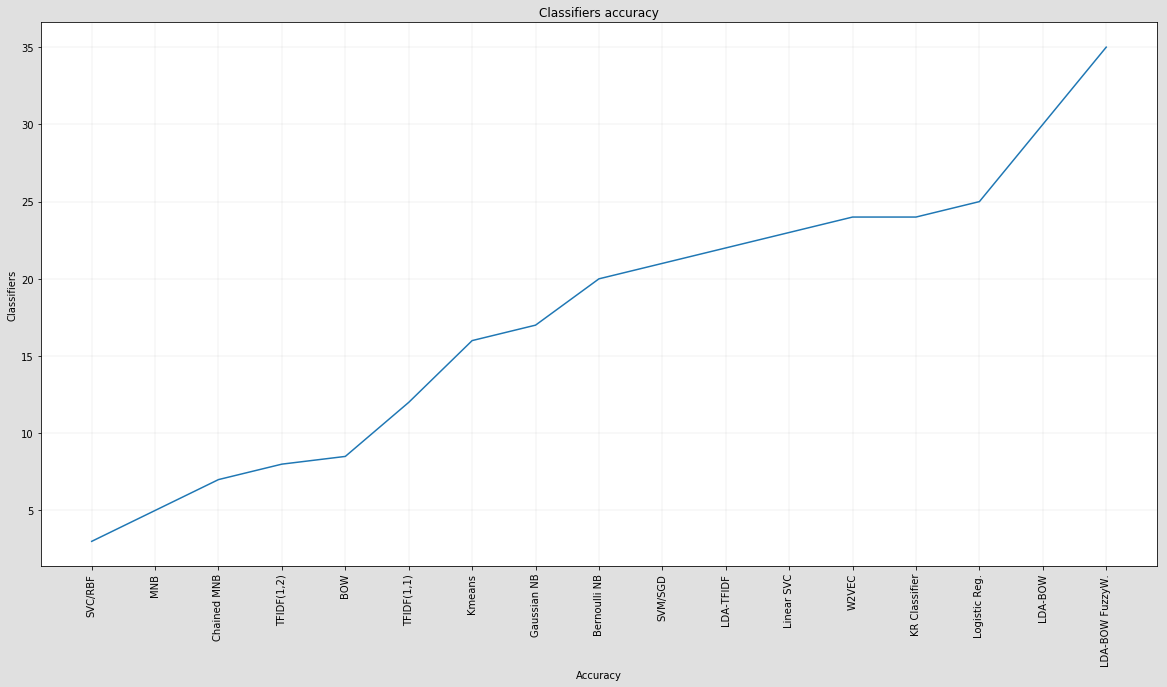

In [58]:
dict_benchmark_result = dict()
dict_benchmark_result['TFIDF(1,2)']=8.0/100
dict_benchmark_result['BOW']=8.5/100
dict_benchmark_result['TFIDF(1,1)']=12/100
dict_benchmark_result['Kmeans']=16/100
dict_benchmark_result['LDA-TFIDF']=22/100
dict_benchmark_result['LDA-BOW']=30/100
dict_benchmark_result['W2VEC']=24/100
dict_benchmark_result['MNB']=5/100
dict_benchmark_result['SVM/SGD']=21/100
dict_benchmark_result['SVC/RBF']=3/100
dict_benchmark_result['Bernoulli NB']=20/100
dict_benchmark_result['Logistic Reg.']=25/100
dict_benchmark_result['Chained MNB']=7./100
dict_benchmark_result['Gaussian NB']=17./100
dict_benchmark_result['Linear SVC']=23./100
dict_benchmark_result['KR Classifier']=24./100

#dict_benchmark_result['KRR Gaussian']=92./100
#dict_benchmark_result['KRR Poly.']=91./100
#dict_benchmark_result['KRR Line.']=86./100
dict_benchmark_result['LDA-BOW FuzzyW.']=35./100


import pandas as pd
df_result = pd.DataFrame.from_dict( dict_benchmark_result, orient='index')
df_result.reset_index(inplace=True)
df_result.rename(columns={'index':'Classifier',0:'Score'}, inplace=True)
df_result

import p6_util_plot
title = "Classifiers accuracy"
p6_util_plot.ser_item_occurency_plot(df_result.Classifier, df_result.Score*100, item_count=None, title=title,\
                                    p_reverse=False)

In [ ]:
RidgeClassifier()

In [ ]:
svm.SVC(gamma='scale')

In [ ]:
from sklearn import svm
svc_clf = svm.SVC(gamma='scale')
file_name = './data/dict_cls_score.dump'
dict_cls_score = p5_util.object_load(file_name)
dict_param_grid = {
    'estimator__C': [ 1.,],
    'n_jobs': [-1]
}
cls_name='SVM Kernel'
dict_cls_score, best_classfier = gscv_best_classifier_result(dict_param_grid, svc_clf, X_train, y_train\
                              , cls_name, X_test,y_test, dict_cls_score)
dict_cls_score